In [78]:
using Pkg
# Pkg.activate("my_environment", shared=true)
# Pkg.add("MLJ")
# Pkg.add("MLJBase")
# Pkg.add("MLJFlux")
using Dates
using Statistics
using DataFrames
using Queryverse
using VegaLite
using MLJ
using MLJBase
using Flux
using MLJFlux


## Objective

The objective is to predict wine quality from wine properties.  Wine quality is ranked from 1-10, however for this analysis a three way partition of good moderate and poor will be used to represent wine quality instead.  Predictor variables includes , fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates and alcohol.

## Data Description

There are 11 potential continuous variables to predict wine quality.  Although wine quality scores ranged between 0 and 10 user scores ranged between 3 and 9 with a mean of 5.81.  An attempt will be made to partition the wine quality into the classes of good, moderate and poor. The data is also relatively clean with no missing values. 

In [79]:
# Load the wine quality data from .csv file
wine = Queryverse.load("/home/chigball/Data/wine.csv") |> DataFrame;
describe(wine)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,fixed_acidity,7.21531,3.8,7.0,15.9,,,Float64
2,volatile_acidity,0.339666,0.08,0.29,1.58,,,Float64
3,citric_acid,0.318633,0.0,0.31,1.66,,,Float64
4,residual_sugar,5.44324,0.6,3.0,65.8,,,Float64
5,chlorides,0.0560339,0.009,0.047,0.611,,,Float64
6,free_sulfur_dioxide,30.5253,1.0,29.0,289.0,,,Float64
7,total_sulfur_dioxide,115.745,6.0,118.0,440.0,,,Float64
8,density,0.994697,0.98711,0.99489,1.03898,,,Float64
9,pH,3.2185,2.72,3.21,4.01,,,Float64


## Data Exploration
The distribution of wine scores was explored in order to define a reasonable partition of good, moderate and poor quality scores. It’s determined that poor (0-5), moderate (6) and good (7-10) are logical choices.

Higher quality wine tend to to have higher alcohol conent on average than lower quality wine.

#### Distribution of Wine Scores

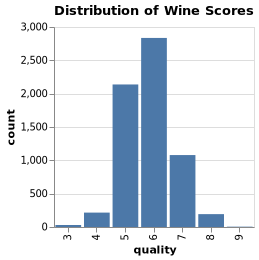

In [80]:
# Plot of distribution of wine scores
@vlplot(
  data = wine,
  mark = :bar,
  x = "quality:n",
  y = {"count()", title = "count"},
  height = 200,
  width = 200,
  title = "Distribution of Wine Scores"
)

#### Alcohol Content by Wine Quality

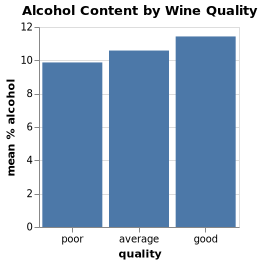

In [81]:
# This is a function that maps scores into the class of poor, average or good
function quality_class(x::Number)
  if x <= 5
    value = "poor"
  elseif x == 6
    value = "average"
  elseif x >=7
    value = "good"
  end
  return(value)
end


# Redefine the variable quality into poor, averge or good
wine1 = wine |> @mutate(quality = quality_class(_.quality)) |> DataFrame;

# Alcohol Content by Wine Quality
@vlplot(
  title = "Alcohol Content by Wine Quality",
  data = wine1,
  mark = :bar,
  x = {"quality:n", sort = "y", axis = {labelAngle=0}},
  y = {"mean(alcohol)", title = "mean % alcohol"},
  width = 200,
  height = 200
)


## Data Preperation
- The target is "quality" as a categorical array (y), while everything else is the predictor variable
- Data was split into training and testing sets at a 70/30 split

In [82]:
# Define X and y
X = wine1 |> @select(-:quality) |> DataFrame
y = categorical(wine1.quality)

# Create an index for model and validation sets
m, v = partition(eachindex(y), 0.7, shuffle=true); 

# Create model/training sets
Xm = X[m,:];
ym = y[m];

# Create validation/testing sets
Xv = X[v,:];
yv = y[v];

## Model Building

A machine learning pipeline was created with a standardizer and a 3 layer neural network .  After some experimentation the number of epochs and batch size was set at 8 and 1 respectively.  

In [85]:
@load NeuralNetworkClassifier;

# Create a builder of ANN with two hiden layers
mutable struct MyANNBuilder <: MLJFlux.Builder
  h1::Int64 # number of neurons in first hiden layer
  h2::Int64 # number of neurons in second hidden layer
end


# Define the build function 
function MLJFlux.build(B::MyANNBuilder, n_in, n_out)
  h1 = B.h1
  h2 = B.h2  
  mychain = Chain(Dense(n_in, h1, relu), Dense(h1, h2, relu), Dense(h2, n_out, relu))
  return(mychain)  
end

# Pipeline with a standardizer and custom NeuralNetworkClassifier
pipe = @pipeline(
  Standardizer(),
  NeuralNetworkClassifier(builder = MyANNBuilder(10,10), epochs = 8, batch_size = 1),
  prediction_type=:probabilistic
)

# Fit machine
mach = machine(pipe, Xm, ym);
fit!(mach);

pipe

Pipeline494(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    neural_network_classifier = NeuralNetworkClassifier(
            builder = MyANNBuilder @959,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 8,
            batch_size = 1,
            lambda = 0.0,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false)) @128

## Model Evaluation

Define resampling strategy

- holdout(70/30 split)

Define measures

- crossentropy, BrierScore, area under curve


In [87]:
# Evaluate model
evaluate!(mach, 
  resampling=Holdout(fraction_train=0.7, shuffle=true, rng=1234),
  measures=[cross_entropy, BrierScore(), area_under_curve],
  check_measure=false,
  verbosity = 0
)

┌──────────────────────────────┬───────────────┬─────────────────┐
│ _.measure                    │ _.measurement │ _.per_fold      │
├──────────────────────────────┼───────────────┼─────────────────┤
│ cross_entropy                │ 0.896         │ Float32[0.896]  │
│ BrierScore{UnivariateFinite} │ -0.546        │ Float32[-0.546] │
│ area_under_curve             │ 0.835         │ [0.835]         │
└──────────────────────────────┴───────────────┴─────────────────┘
_.per_observation = [[[0.92, 0.608, ..., 0.412]], [[-0.668, -0.33, ..., -0.215]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


Here is the model accuracy. When taking 3 classes in account the accuracy is above (> 0.33) the baseline.  

In [88]:
# Here we test predictions actual results using the Xv data
acc = accuracy(predict_mode(mach, Xv), yv);
acc = round(acc, digits = 3);

println("The final accuracy is $(acc)")


The final accuracy is 0.576
